(chap:14-hetero)=
# 不均一分散

<div name="html-admonition" style="font-size: 0.8em">
<input type="button" onclick="location.href='https://translate.google.com/translate?hl=&sl=ja&tl=en&u='+window.location;" value="Google translation" style="color:#ffffff;background-color:#008080; height:25px" onmouseover="this.style.background='#99ccff'" onmouseout="this.style.background='#008080'"/> in English or the language of your choice.
</div><br>

In [1]:
import matplotlib.pyplot as plt
import lmdiag
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import wooldridge

from seaborn import residplot
from statsmodels.stats.api import het_breuschpagan, het_white
from statsmodels.stats.outliers_influence import reset_ramsey

# 警告メッセージを非表示
import warnings
warnings.filterwarnings("ignore")

## 説明

**＜仮定５（均一分散; Homogeneity）が満たされない場合＞**

仮定５の均一分散の下では説明変数は誤差項の分散に影響を与えない。即ち，

$$\text{Var}\left(u|x\right)=\sigma^2$$

この仮定に関連して次の点について留意する必要がある。
* 均一分散が満たされない場合でも，
    * 仮定１〜４のもとでOLS推定量 $\hat{\beta}_j$の不遍性と一致性は成立する。
    * $R^2$の解釈は変わらない。
* しかし，均一分散が満たされない場合，
    * OLS推定量の標準偏差の推定量である標準誤差$\text{se}\left(\hat{\beta}_j\right)$は無効となる。従って，$t$検定と$F$検定も無効になる。
    * 大標本特性（漸近的特性）も成立しない。従って，大標本であっても$t$検定と$F$検定も無効になる。

仮説を検証するということを目的とすると，検定が無効というのは致命的な問題である。特に，不均一分散（Heteroskedasticity）の問題は，横断面データを使うと頻繁に出てくる問題である。ではどのように対応すればよいのか。

---
**不均一分散頑健的推定（Heteroskedasticity-Robust Inference）**

この手法を使うと，OLS推定量の標準誤差が調整され**未知の**不均一分散であっても，$t$検定，$F$検
定が有効になるというものである。

（理由）均一分散であっても不均一分散であっても，$n\rightarrow\infty$の場合，不均一分散頑健的推定の$t$($F$)値は$t$($F$)分布に従う。言い換えると，標本の大きさが十分に大きければ，$t$($F$)値の分布は$t$($F$)分布で近似できるということである。

更なる利点は，通常のOLS推定の後に標準誤差の調整が施され，計算は`statsmodels`を使うと簡単におこなうことが可能である。

（注意）大標本でのみ有効。

---
不均一分散頑健的推定では，OLS推定の共分散行列（covariance matrix）と呼ばれる箇所を調整し，OLS推定量の標準誤差を修正する。その調整方法が複数提案されていおり，`statsmodels`では以下の種類に対応している。
* `HC0`: White (1980)の不均一分散頑健共分散行列推定
* `HC1`: MacKinnon and White (1985)の不均一分散頑健共分散行列推定v1
* `HC2`: MacKinnon and White (1985)の不均一分散頑健共分散行列推定v2
* `HC3`: MacKinnon and White (1985)の不均一分散頑健共分散行列推定v3

ここで`HC`は`H`eteroskedasticity-`C`onsistent Covariance Matrix Estimatorsの`H`と`C`。

不均一分散頑健共分散行列推定を使い計算した$t$値や$F$値を**頑健的$t$値**，**頑健的$F$値**と呼ぶことにする。

````{note}
`HC0`などは不均一分散に対応する推定方法である。一方で，時系列分析では残差に不均一分散と自己相関の両方が存在する場合がある。この両方の問題に頑健的な推定を不均一分散・自己相関頑健推定（Heteroskedasticity-Autocorrelation Robust Inference）と呼ぶ。次の引数を使うことにより，不均一分散・自己相関頑健標準誤差を計算することができる。
```
cov_type='HAC', cov_kwds={'maxlags': n}, use_t=True
```
* `cov_type='HAC'`：不均一分散・自己相関頑健推定の指定
* `cov_kwds={'maxlags': n}`（必須）：`n`は残差のラグを示す。`n`の値に基づきパラメータの推定値の標準誤差を調整する，`n`はその際に使うラグの最大値。`n=10`とすれば，最大`10`までのラグを計算し，その中で「最適な」値を使うことになる。標本の大きさより小さな値を設定する必要があり，例えば，`5`，`10`，`20`などを使い，標準誤差がどう変化するかを確認する必要があるだろう。残差の自己相関を考え，`n`を設定すれば良いだろう。
* `use_t=True`（必須ではない）：`t`検定を使うことを指定する。

ちなみに，`HC`はHeteroskedasticity Consistentの略であり，`HAC`はHeteroskedasticity-Autocorrelation Consistent`の略である。
````

---
OLS推定量の不均一分散頑健標準偏差が簡単に計算できるのであれば，通常の標準偏差を使う必要はないのではないか，という疑問が生じる。この問を関して以下の点を考える必要がある。
* 通常の標準偏差を使う利点
    * 均一分散の場合（仮定1〜6（CLR仮定）），標本の大きさの大小に関わらず，$t$ ($F$)値の分布は**厳密に** $t$ ($F$)分布に従う。
* 不均一分散頑健標準偏差
    * 小標本の場合
        * 頑健的 $t$ ($F$)値の分布は必ずしも $t$ ($F$)分布に従うわけではない。その場合，$t$ ($F$)検定は無効となる。
    * 大標本の場合
        * $t$ ($F$)値の分布は $t$ ($F$)分布で**近似**され，$t$ ($F$)検定は有効である。
        * この結果は仮定１〜６（CLR仮定）のもとでも同じ。

従って，標本の大きさが「大標本」と判断できる場合（例えば，$n\geq 1000$）以外は通常の標準偏差と不均一分散頑健標準偏差の両方を表示することを勧める。

## 頑健的$t$検定

`wooldridge`パッケージのデータセット`gpa3`を使い説明する。この例では大学のGPAと高校の成績や性別，人種などがどのような関係にあるかを探る。

In [2]:
gpa3 = wooldridge.data('gpa3').query('spring == 1')  # 春学期だけを抽出
wooldridge.data('gpa3', description=True)

name of dataset: gpa3
no of variables: 23
no of observations: 732

+----------+------------------------------+
| variable | label                        |
+----------+------------------------------+
| term     | fall = 1, spring = 2         |
| sat      | SAT score                    |
| tothrs   | total hours prior to term    |
| cumgpa   | cumulative GPA               |
| season   | =1 if in season              |
| frstsem  | =1 if student's 1st semester |
| crsgpa   | weighted course GPA          |
| verbmath | verbal SAT to math SAT ratio |
| trmgpa   | term GPA                     |
| hssize   | size h.s. grad. class        |
| hsrank   | rank in h.s. class           |
| id       | student identifier           |
| spring   | =1 if spring term            |
| female   | =1 if female                 |
| black    | =1 if black                  |
| white    | =1 if white                  |
| ctrmgpa  | change in trmgpa             |
| ctothrs  | change in total hours        |
| ccrsgpa

`gpa2`に一部の変数の説明が続いている。

In [3]:
wooldridge.data('gpa2', description=True)

name of dataset: gpa2
no of variables: 12
no of observations: 4137

+----------+----------------------------------+
| variable | label                            |
+----------+----------------------------------+
| sat      | combined SAT score               |
| tothrs   | total hours through fall semest  |
| colgpa   | GPA after fall semester          |
| athlete  | =1 if athlete                    |
| verbmath | verbal/math SAT score            |
| hsize    | size grad. class, 100s           |
| hsrank   | rank in grad. class              |
| hsperc   | high school percentile, from top |
| female   | =1 if female                     |
| white    | =1 if white                      |
| black    | =1 if black                      |
| hsizesq  | hsize^2                          |
+----------+----------------------------------+

For confidentiality reasons, I cannot provide the source of these
data. I can say that  they come from a midsize research university
that also supports men’s and w

### OLS推定

被説明変数：
* `cumgpa`：累積GPA

説明変数
* `sat`：SATの成績
* `hsperc`：高校の成績の％点（上位から）
* `tothrs`：データ抽出時から学期までの時間？（`gpa3`の定義）
* `female`：女性ダミー変数（女性＝`1`）
* `black`：人種ダミー変数（黒人＝`1`）
* `white`：人種ダミー変数（白人＝`1`）

In [4]:
form_ols = 'cumgpa ~ sat + hsperc + tothrs + female + black + white'

mod_ols = smf.ols(form_ols, data=gpa3)
res_ols = mod_ols.fit()

print(res_ols.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4701      0.230      6.397      0.000       1.018       1.922
sat            0.0011      0.000      6.389      0.000       0.001       0.001
hsperc        -0.0086      0.001     -6.906      0.000      -0.011      -0.006
tothrs         0.0025      0.001      3.426      0.001       0.001       0.004
female         0.3034      0.059      5.141      0.000       0.187       0.420
black         -0.1283      0.147     -0.870      0.385      -0.418       0.162
white         -0.0587      0.141     -0.416      0.677      -0.336       0.219


### 不均一分散頑健推定：方法１

上のOLSの結果を使い頑健$t$値を計算するために，`res_ols`のメソッド`.get_robustcov_results()`を使う。
* オプション`cov_type`は頑健性の計算法の指定（デフォルトは`CH1`）。
* オプション`use_t`は$t$検定を指定（デフォルトは`None`で「自動」に決められる）

In [5]:
res_robust = res_ols.get_robustcov_results(cov_type='HC3', use_t=True)

print(res_robust.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4701      0.229      6.409      0.000       1.019       1.921
sat            0.0011      0.000      5.840      0.000       0.001       0.002
hsperc        -0.0086      0.001     -5.934      0.000      -0.011      -0.006
tothrs         0.0025      0.001      3.342      0.001       0.001       0.004
female         0.3034      0.060      5.054      0.000       0.185       0.422
black         -0.1283      0.128     -1.001      0.318      -0.380       0.124
white         -0.0587      0.120     -0.488      0.626      -0.296       0.178


1. OLS推定量`coef`の値は同じであり，必ずそうなる。不均一分散頑健推定は，表の中で標準誤差，$t$値，$p$値，信頼区間に影響を与える。
2. 標準誤差`std err`を比べると，帰無仮説$\hat{\beta}_j=0$の棄却判断を覆すほど大きく変わる変数はない。これは不均一分散がそれほど大きな問題ではないことを示唆している。この点を確かめるために，`res_ols`の誤差項を図示してみる。

誤差項を図示する方法として２つを紹介する。一つ目は，`res_ols`の属性`.resid`を使う。`res_ols.resid`は`Pandas`の`Series`（シリーズ）なので，そのメソッド`plot()`を使い図示する。`style`はマーカーを指定するオプション。

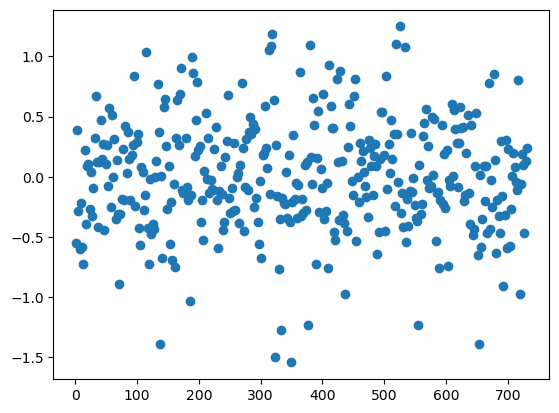

In [6]:
res_ols.resid.plot(style='o')
pass

２つ目の方法は`plt.plot()`を使う。オップション`'o'`はマーカの指定である。

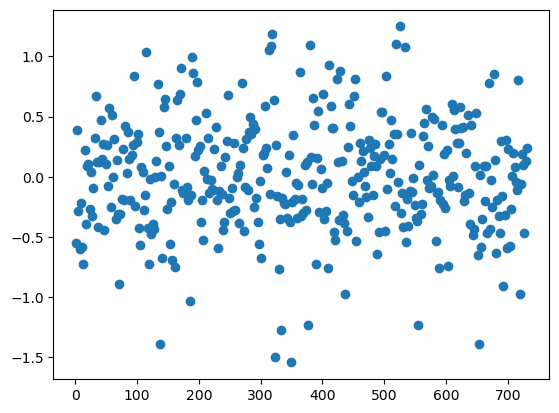

In [7]:
plt.plot(res_ols.resid, 'o')
pass

３つ目は`scatter()`を使う。`.index`は`res_ols.resd`の属性でインデックスを示す。

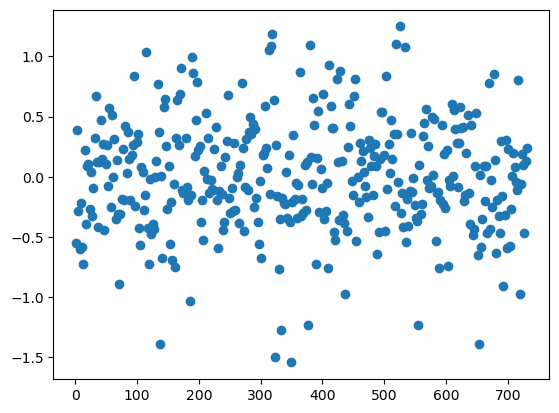

In [8]:
plt.scatter(res_ols.resid.index, res_ols.resid)
pass

### 不均一分散頑健推定：方法２

OLS推定をする際，`fit()`の関数に`.get_robustcov_results()`で使った同じオプションを追加すると頑健$t$値などを直接出力できる。

In [9]:
res_HC3 = smf.ols(form_ols, data=gpa3).fit(cov_type='HC3', use_t=True)

print(res_HC3.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4701      0.229      6.409      0.000       1.019       1.921
sat            0.0011      0.000      5.840      0.000       0.001       0.002
hsperc        -0.0086      0.001     -5.934      0.000      -0.011      -0.006
tothrs         0.0025      0.001      3.342      0.001       0.001       0.004
female         0.3034      0.060      5.054      0.000       0.185       0.422
black         -0.1283      0.128     -1.001      0.318      -0.380       0.124
white         -0.0587      0.120     -0.488      0.626      -0.296       0.178


## 頑健的$F$検定

同じデータ`gpa3`を使い，黒人ダミーと白人ダミーの係数は両方とも`0`という仮説を検定する。

In [10]:
hypotheses = 'black = white = 0'

まず通常の$F$検定を考える。

In [11]:
f_test_ols = res_ols.f_test(hypotheses)

f_test_ols.summary()

'<F test: F=0.6796041956073321, p=0.5074683622584049, df_denom=359, df_num=2>'

返り値（左から）
* `F statistic`：$F$統計量
* `F p-value`：$F$の$p$値
* `df_denom`：分母の自由度
* `df_num`：分子の自由度

次に頑健$F$検定の方法を説明する。上の不均一分散頑健推定の方法２で使った`f_test_HC3`を使う。

In [12]:
f_test_HC3 = res_HC3.f_test(hypotheses)

f_test_HC3.summary()

'<F test: F=0.672469295765663, p=0.5110883633440992, df_denom=359, df_num=2>'


$t$検定の場合と同じように，大きく変わる結果につながってはない。

## 均一分散の検定

均一分散の場合 $t$($F$)値は厳密に$t$($F$)分散に従う。それが故に，均一分散が好まれる理由である。ここでは均一分散の検定について考える。帰無仮説と対立仮説は以下となる。

$\text{H}_0$：誤差項は均一分散

$\text{H}_A$：帰無仮説は成立しない

２つの検定方法を考える。

### ブルーシュ・ペーガン（Breusch-Pagan）検定

データ`hprice1`を使って，住宅価格の決定要因を検討する。ここで考える均一分散の検定にBreusch-Pagan検定と呼ばれるもので，`statsmodels`のサブパッケージ`stats`の関数`het_breuschpagan`を使う。

In [13]:
hprice1 = wooldridge.data('hprice1')
wooldridge.data('hprice1', description=True)

name of dataset: hprice1
no of variables: 10
no of observations: 88

+----------+------------------------------+
| variable | label                        |
+----------+------------------------------+
| price    | house price, $1000s          |
| assess   | assessed value, $1000s       |
| bdrms    | number of bdrms              |
| lotsize  | size of lot in square feet   |
| sqrft    | size of house in square feet |
| colonial | =1 if home is colonial style |
| lprice   | log(price)                   |
| lassess  | log(assess                   |
| llotsize | log(lotsize)                 |
| lsqrft   | log(sqrft)                   |
+----------+------------------------------+

Collected from the real estate pages of the Boston Globe during 1990.
These are homes that sold in the Boston, MA area.


以下で使う変数について。

被説明変数
* `price`：住宅価格（単位：1000ドル）

説明変数
* `lotsize`：土地面積（単位：平方フィート）
* `sqrft`：家の面積（単位：平方フィート）
* `bdrms`：寝室の数

#### 対数変換前

まず変数の変換をしない場合を考える。

In [14]:
form_h = 'price ~ lotsize + sqrft + bdrms'

res_h = smf.ols(form_h, data=hprice1).fit()

print(res_h.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -21.7703     29.475     -0.739      0.462     -80.385      36.844
lotsize        0.0021      0.001      3.220      0.002       0.001       0.003
sqrft          0.1228      0.013      9.275      0.000       0.096       0.149
bdrms         13.8525      9.010      1.537      0.128      -4.065      31.770


この結果に対してBreusch-Pagan検定をおこなう。`het_breuschpagan()`の引数について：
* 第１引き数：OLSの結果`res_h`の属性`.resid`で誤差項の値
* 第２引き数：OLSの結果`res_h`の属性`.model`の属性`exog`を使い定数項を含む説明変数の値

In [15]:
het_breuschpagan(res_h.resid, res_h.model.exog)

(14.092385504350194,
 0.0027820595556891452,
 5.338919363241398,
 0.002047744420936124)

返り値（上から）
* `LM statistic`：$LM$統計量
* `LM p-value`：$LM$の$p$値
* `F statistics`：$F$統計量
* `F p-value`：$F$の$p$値

$LM$検定とはLagrange Multiplier検定のことで，大標本の場合に仮定１〜４（GM仮説）のもとで成立する。一般にBreusch-Pagan検定は$LM$統計量を使ったものを指すが，$F$統計量としても計算できる。

5%の有意水準で帰無仮説（$\text{H}_0$：誤差項は均一分散）を棄却でき，不均一分散の可能性が高い。対処法として変数の変換が挙げられる。

#### 対数変換

`bdrms`以外を対数変換する。

In [16]:
form_h_log = 'np.log(price) ~ np.log(lotsize) + np.log(sqrft) + bdrms'

res_h_log = smf.ols(form_h_log, data=hprice1).fit()

print(res_h_log.summary().tables[1])

                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.2970      0.651     -1.992      0.050      -2.592      -0.002
np.log(lotsize)     0.1680      0.038      4.388      0.000       0.092       0.244
np.log(sqrft)       0.7002      0.093      7.540      0.000       0.516       0.885
bdrms               0.0370      0.028      1.342      0.183      -0.018       0.092


In [17]:
het_breuschpagan(res_h_log.resid, res_h_log.model.exog)

(4.223245741805276, 0.23834482631492962, 1.411499906120807, 0.2451456613048952)

5%の有意水準でお帰無仮説を棄却できない。即ち，対立仮説（$\text{H}_A$：帰無仮説は成立しない）を採択し，均一分散の可能性が高い。

### ホワイト（White）検定

この検定はOLS推定量の標準誤差と検定統計量を無効にする不均一分散を主な対象としており，Breusch-Pagan検定よりもより一般的な式に基づいて検定をおこなう。`statsmodels`のサブパッケージ`stats`の関数`het_white`を使う。

`hprice`のデータを使った上の例を使う。

`het_white()`の引数：
* 第１引き数：OLSの結果`res_h`の属性`.resid`で誤差項の値
* 第２引き数：OLSの結果`res_h`の属性`.model`の属性`exog`を使い定数項を含む説明変数の値

#### 対数変換前

In [18]:
het_white(res_h.resid, res_h.model.exog)

(33.73165771109837,
 9.952939773734263e-05,
 5.386953445894594,
 1.0129388323900798e-05)

返り値（上から）
* `LM statistic`：$LM$統計量
* `LM p-value`：$LM$の$p$値
* `F statistics`：$F$統計量
* `F p-value`：$F$の$p$値

一般にWhite検定は$LM$統計量を使ったものを指すが，$F$統計量としても計算できる。

5%の有意水準で帰無仮説（$\text{H}_0$：誤差項は均一分散）を棄却でき，不均一分散の可能性が高い。対処法として変数の変換が挙げられる。

#### 対数変換後

In [19]:
het_white(res_h_log.resid, res_h_log.model.exog)

(9.549452426207322, 0.3881739919107559, 1.0549565756603805, 0.4053123705653099)

5%の有意水準で帰無仮説を棄却できない。即ち，対立仮説（$\text{H}_A$：帰無仮説は成立しない）を採択し，均一分散の可能性が高い。


## 残差：図示と線形性

## 図示

仮定４〜６は残差に関するものであり，残差をプロットし不均一分散や非線形性を確認することは回帰分析の重要なステップである。

残差を図示する方法として`lmdiag`以外に以下を紹介する。
1. `matplotlib`を直接使う
2. `seaborn`というパッケージの中にある関数`residplot`を使う

上で計算した`res_h`と`res_h_log`を利用し
* 横軸：被説明変数の予測値（メソッド`.fittedvalues`）
* 縦軸：残差（メソッド`.resid`）

となる図を作成する。

### `lmdiag`

対数変換前

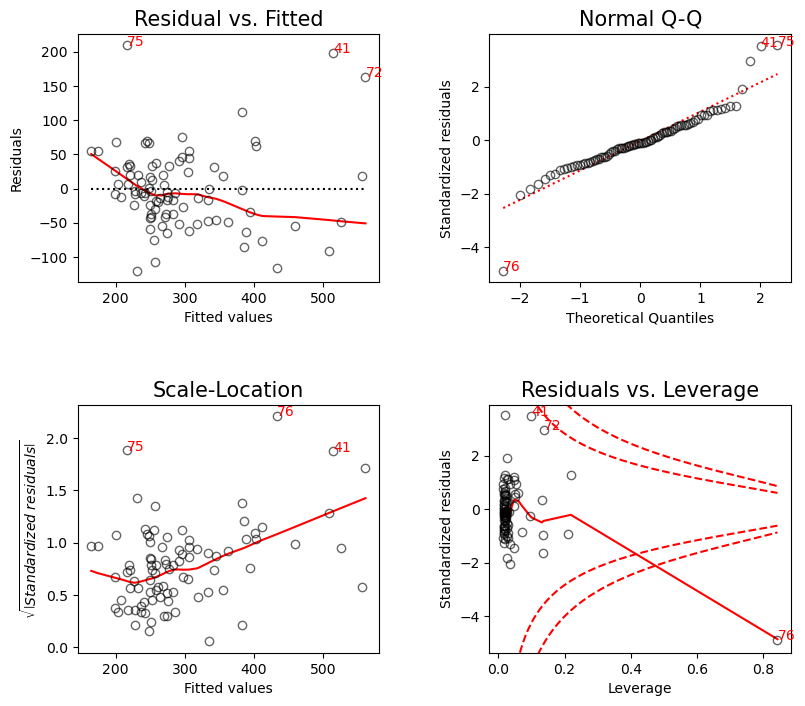

In [20]:
plt.figure(figsize=(8,7))
lmdiag.plot(res_h)
pass

対数変換後

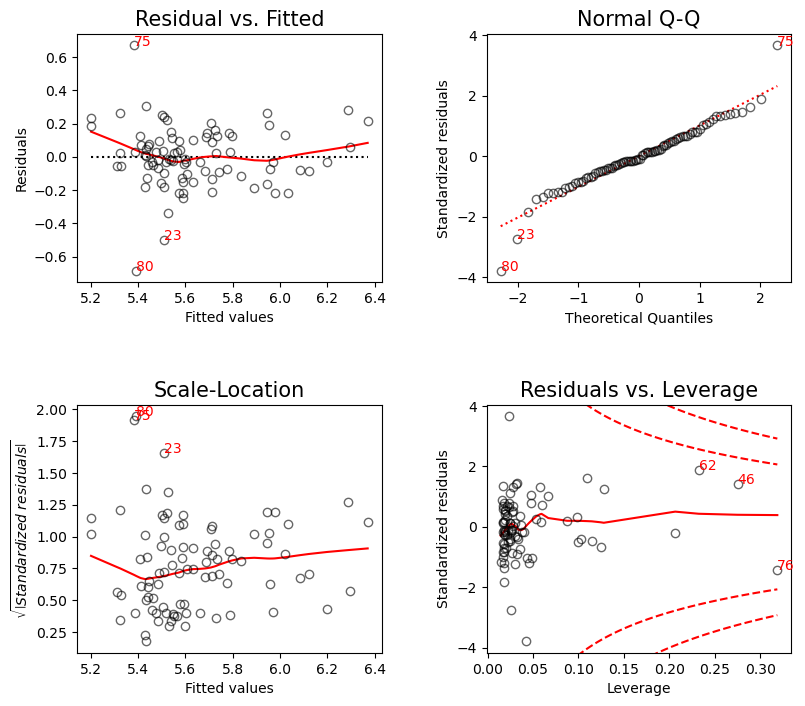

In [21]:
plt.figure(figsize=(8,7))
lmdiag.plot(res_h_log)
pass

対数変換により残差の変化がより均一的になり，Residuals vs. LeverageのCook's Distanceを見ても外れ値がなくなっている。

### `Matplotlib`の`plot()`

対数変換前

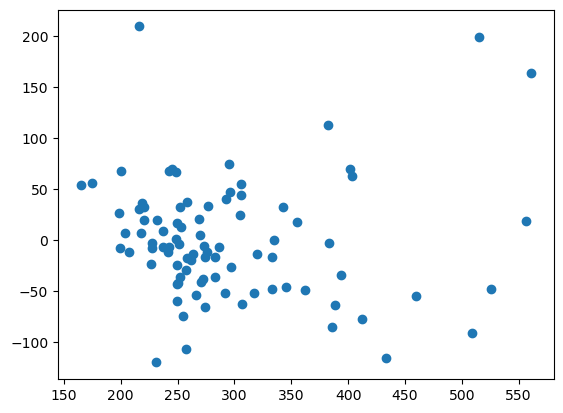

In [22]:
plt.scatter(res_h.fittedvalues, res_h.resid)
pass

対数変換後

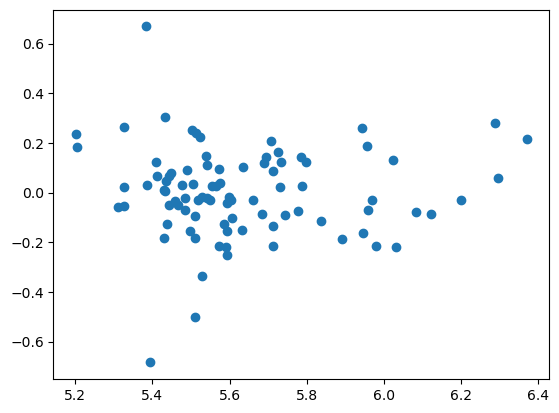

In [23]:
plt.scatter(res_h_log.fittedvalues, res_h_log.resid)
pass

対数変換により残差の変化がより均一的になったのが確認できる。

### `seaborn`の`residplot()`

`seaborn`は`matplotlib`を利用し様々な図を描ける。`seaborn`については[このサイト](https://seaborn.pydata.org/index.html)を参照。

通常`import seaborn as sns`でインポートすることが多いようであるが，ここでは`residplot`のみをインポートしている。

`residplot()`は散布図を作成する関数である。
* `x=`：横軸の変数を指定
    * 被説明変数を設定することを勧める。
* `y=`：縦軸の変数を指定
    * 残差
* オプション
    * `lowerss=True`（デフォルトは`False`）にすると，散布図にベスト・フィットする**曲線**を表示する。

---
対数変換前

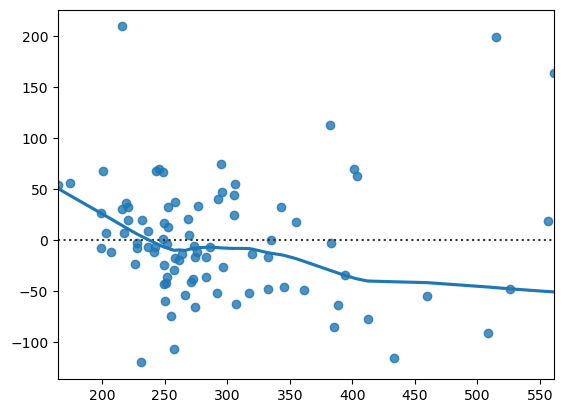

In [24]:
residplot(x=res_h.fittedvalues, y=res_h.resid, lowess=True)
pass

対数変換後

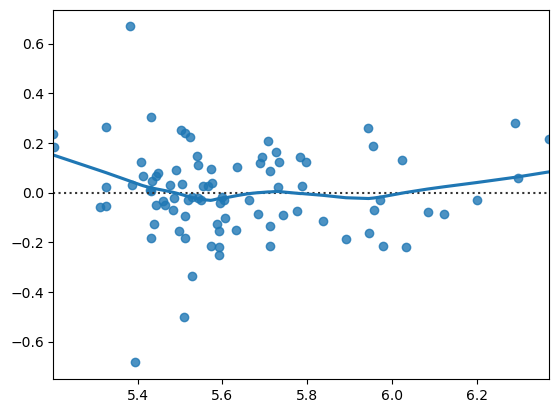

In [25]:
residplot(x=res_h_log.fittedvalues, y=res_h_log.resid, lowess=True)
pass

## 線形性

仮定１で回帰式は線形となっているが，その仮定が正しければ，上の残差の散布図は概ね平行にそして０を中心に上下等間隔に散らばることになる。そのパターンに比較的に近いのは対数変換**後**の図である。不均一分散の場合は，そのパターンが大きく崩れている場合であり，その原因のその１つに回帰式の特定化の間違いがある。例えば，説明変数の２乗が含まれるべきなのに欠落している場合が挙げられる。極端な場合，残差の散布図は$U$字または逆$U$字のような形になりえる。

一方，線形性の検定もある。以下ではその１つである RESET (Regression Specification Error Test) 検定を考える。

この検定の考え方はそれほど難しくはない。次の回帰式を推定するとしよう。

$$y=\beta_0+\beta_1x_1+\beta_2x_2+u$$

この線形式が正しければ，$x_1^2$や$x_2^3$等を追加しても統計的に有意ではないはずである。さらに，この線形回帰式の予測値$\hat{y}$は$x_1$や$x_2$の線形になっているため、$\hat{y}^2$や$\hat{y}^3$は$x_1$や$x_2$の非線形となっている。従って，次式を推計し，もし非線形の効果がなければ$\delta_1$も$\delta_2$も有意ではないはずである。

$$y=\beta_0+\beta_1x_1+\beta_2x_2+\delta_1\hat{y}^2+\delta_2\hat{y}^3$$

この考えに基づいて以下の仮説を検定する。

$\text{H}_0:\;\delta_1=\delta_2=0$（線形回帰式が正しい）

$\text{H}_A$: $\text{H}_0$は成立しない 

＜コメント＞
* 通常は$y$の3乗まで含めれば十分であろう。
* 大標本のもとで$F$検定統計値は$F$分布に従う。


---
`statsmodels`のサブパッケージ`.stats.outliers_influence`のRESET検定用の関数`reset_ramsey`を使う。（`ramsey`はこの検定を考案した学者名前）

`reset_ramsey()`の使い方：
* 引き数：OLS推定の結果
* オプションの`degree`（デフォルトは5）は$y$の何乗までを含めるかを指定する。

**対数変換前**

In [26]:
reset_ramsey(res_h,degree=3).summary()

'<F test: F=4.668205534948522, p=0.01202171144288588, df_denom=82, df_num=2>'

返り値
* `F`: $F$統計量
* `p`: $p$値
* `df_denom`: 分母の自由度
* `df_num`: 分子の自由度（２乗以上の制約数）

**対数変換後**

In [27]:
reset_ramsey(res_h_log,degree=3)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=2.5650407879824693, p=0.08307588974934489, df_denom=82, df_num=2>

5%の有意水準のもとで，`res_h`の帰無仮説を棄却できるが，`res_h_log`では棄却できない。後者の推計式がより適しているようである。